## OKX BOT POSITION ANALYSIS

Comparison between signal given theoretical position of the strategy (current_state.log) and actual executed position in production, built from OKX API polling data periodically (current_state.pos)

In [1]:
import re
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from main import *


In [ ]:
def load_positions_3(positions_path: str) -> pd.DataFrame:
    """
    Load positions_3.csv and convert quantities to directions.
    
    Args:
        positions_path (str): Path to positions_3.csv.
    
    Returns:
        pd.DataFrame: DataFrame with timestamps as index and directions (1, -1, 0) for each symbol.
    """
    df = pd.read_csv(positions_path, index_col=0, parse_dates=True)
    df.index = df.index.tz_localize(None)  # Remove timezone for consistency
    # Convert quantities to directions: >0 -> 1, <0 -> -1, 0 -> 0
    df = df.applymap(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
    return df

In [3]:
def parse_current_state_log(log_path: str) -> pd.DataFrame:
    """
    Parse current_state.log into a DataFrame with timestamps as index and tickers as columns.
    The log file is expected to have lines with the following format:
    
        2025/02/28 00:16:52.837068 'AXS-USDT-SWAP'; 1, 'DOGE-USDT-SWAP'; -1, 'LINK-USDT-SWAP'; 1
    
    For each line:
      - The first 26 characters are the timestamp.
      - The regex extracts the symbol and the integer value (with an optional sign).
      - If a ticker is not present in a new line, it is assumed that the position is closed (0).
      - If multiple lines share the same timestamp, the last one is kept.
    
    Args:
        log_path (str): Path to current_state.log.
    
    Returns:
        pd.DataFrame: DataFrame with timestamps as index and columns for each ticker.
    """
    # New regex: Accept a colon or semicolon as delimiter
    pattern = re.compile(r"'([^']+)'\s*:\s*([-+]?\s*\d+)(?:,|$)")
    entries = []
    
    with open(log_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Extract the timestamp (first 26 characters)
            dt_str = line[:26]
            rest = line[26:].strip()
            try:
                dt = datetime.strptime(dt_str, "%Y/%m/%d %H:%M:%S.%f")
            except Exception:
                continue
            matches = pattern.findall(rest)
            positions_dict = {}
            for sym, val_str in matches:
                if not re.match(r'^[A-Z0-9]+-USDT-SWAP$', sym):
                    continue
                ticker = sym.split('-')[0]
                try:
                    value_int = int(val_str.replace(" ", ""))
                except Exception:
                    continue
                positions_dict[ticker] = value_int
            entries.append({"timestamp": dt, "positions": positions_dict})
    
    if not entries:
        return pd.DataFrame()
    
    # Merge entries with duplicate timestamps (last one wins)
    timestamp_dict = {}
    for entry in entries:
        ts = entry["timestamp"]
        if ts in timestamp_dict:
            timestamp_dict[ts].update(entry["positions"])
        else:
            timestamp_dict[ts] = entry["positions"]
    
    # Sort timestamps and collect all unique tickers
    timestamps = sorted(timestamp_dict.keys())
    all_tickers = set()
    for positions in timestamp_dict.values():
        all_tickers.update(positions.keys())
    all_tickers = sorted(all_tickers)
    
    # Build the DataFrame incrementally
    df_data = []
    current_positions = {ticker: 0 for ticker in all_tickers}
    
    for ts in timestamps:
        positions = timestamp_dict[ts]
        # Update current positions for tickers present in this snapshot
        for ticker, value in positions.items():
            current_positions[ticker] = value
        # For tickers not mentioned in this snapshot, set them to 0 (position closed)
        for ticker in all_tickers:
            if ticker not in positions:
                current_positions[ticker] = 0
        row = {"timestamp": ts}
        row.update(current_positions.copy())
        df_data.append(row)
    
    df = pd.DataFrame(df_data)
    if df.empty:
        return pd.DataFrame()
    
    df.set_index("timestamp", inplace=True)
    df.sort_index(inplace=True)
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    return df

In [4]:
def parse_executed_positions_log(log_path: str) -> pd.DataFrame:
    """
    Parse current_state.pos into a DataFrame with timestamps as index and tickers as columns.
    First builds a DataFrame with raw position quantities, then processes it to apply a dust threshold
    based on dollar value (< $140 absolute value), and finally converts to +1, -1, 0 positions.
    
    Args:
        log_path (str): Path to current_state.pos.
    
    Returns:
        pd.DataFrame: DataFrame with timestamps as index and position directions for each ticker.
    """
    pattern = re.compile(r"'([^']+)':([-]?\d+\.\d+|\d+)")
    valid_symbols = set()
    invalid_symbols = set()
    data = []
    all_tickers = set()
    
    try:
        with open(log_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                dt_str = line[:24]
                rest = line[24:].strip()
                dt = datetime.strptime(dt_str, "%Y/%m/%d %H:%M:%S.%f")
                pairs = pattern.findall(rest)
                positions_dict = {}
                for sym, pos in pairs:
                    if sym == 'equity':
                        continue
                    if sym in invalid_symbols:
                        continue
                    if sym.isdigit():
                        print(f"ERROR: Invalid numerical symbol '{sym}' at {dt_str}, skipping")
                        invalid_symbols.add(sym)
                        continue
                    if not re.match(r'^[A-Z0-9]+-[A-Z]+-(SWAP|PERP)$', sym):
                        print(f"WARNING: Symbol '{sym}' at {dt_str} does not match expected format, skipping")
                        invalid_symbols.add(sym)
                        continue
                    if sym not in valid_symbols:
                        valid_symbols.add(sym)
                    ticker = sym.split('-')[0]
                    all_tickers.add(ticker)
                    # Store the raw position quantity (float)
                    positions_dict[ticker] = float(pos)
                data.append({"timestamp": dt, "positions": positions_dict})
    except FileNotFoundError as e:
        print(f"ERROR: File not found: {log_path}")
        raise e
    
    if not data:
        return pd.DataFrame()
    
    # Build a timestamp dictionary with raw quantities
    timestamp_dict = {}
    for entry in data:
        ts = entry["timestamp"]
        if ts not in timestamp_dict:
            timestamp_dict[ts] = {}
        timestamp_dict[ts].update(entry["positions"])
    
    timestamps = sorted(timestamp_dict.keys())
    positions_list = [timestamp_dict[ts] for ts in timestamps]
    
    # Create a DataFrame with raw quantities
    df_data = []
    for ts, positions in zip(timestamps, positions_list):
        row = {"timestamp": ts}
        for ticker in all_tickers:
            row[ticker] = 0.0  # Default to 0.0 (float)
        for ticker, qty in positions.items():
            row[ticker] = qty
        df_data.append(row)
    
    qty_df = pd.DataFrame(df_data)
    qty_df.set_index("timestamp", inplace=True)
    qty_df.sort_index(inplace=True)
    
    return qty_df


def get_next_bar_price(symbol: str, ts: pd.Timestamp, df_prices: pd.DataFrame, column: str = "close", fallback: bool = False) -> float:
    """Helper function to get the next available price."""
    col = f"{symbol}-USDT-SWAP_{column}"
    if col not in df_prices.columns:
        return float("nan")
    prices_after = df_prices[df_prices.index >= ts][col]
    if not prices_after.empty:
        return prices_after.iloc[0]
    if fallback:
        prices_before = df_prices[df_prices.index <= ts][col]
        if not prices_before.empty:
            return prices_before.iloc[-1]
    return float("nan")

def calculate_position_values(qty_df: pd.DataFrame, price_data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the dollar value of positions by multiplying quantities with next bar prices.
    
    Args:
        qty_df (pd.DataFrame): DataFrame with timestamps as index and raw position quantities.
        price_data (pd.DataFrame): DataFrame with prices (index: timestamps, columns: tickers).
    
    Returns:
        pd.DataFrame: DataFrame with timestamps as index and dollar values for each ticker.
    """
    values_df = qty_df.copy()
    
    for ts in values_df.index:
        for ticker in values_df.columns:
            qty = values_df.at[ts, ticker]
            if qty == 0:
                values_df.at[ts, ticker] = 0.0
                continue
            
            price = get_next_bar_price(ticker, ts, price_data)
            
            values_df.at[ts, ticker] = qty * price if not pd.isna(price) else float("nan")
    
    return values_df

def apply_dust_threshold(values_df: pd.DataFrame, threshold: float = 140.0) -> pd.DataFrame:
    """
    Apply a dust threshold to the position values DataFrame. Filter out positions with
    absolute dollar value less than threshold, then convert to +1, -1, 0 directions.
    
    Args:
        values_df (pd.DataFrame): DataFrame with timestamps as index and dollar values.
        threshold (float): Dollar value threshold below which a position is considered dust.
    
    Returns:
        pd.DataFrame: DataFrame with +1, -1, 0 positions after applying the threshold.
    """
    # Copy the values DataFrame
    adjusted_df = values_df.copy()
    
    # Filter out values where absolute value is less than threshold (set to 0)
    adjusted_df = adjusted_df.mask(adjusted_df.abs() < threshold, 0.0)
    
    # Convert to directional DataFrame (+1, -1, 0)
    directional_df = adjusted_df.copy()
    directional_df = directional_df.apply(lambda x: x.map(lambda y: 1 if y > 0 else -1 if y < 0 else 0))

    
    return directional_df


In [5]:
def plot_ticker(positions_3_df, log_df, pos_df, ticker, dfs_to_plot=[1, 2, 3]):
    """
    Plot the values of a chosen ticker for the specified DataFrames.
    
    Args:
        positions_3_df (pd.DataFrame): DataFrame from positions_3.csv.
        log_df (pd.DataFrame): DataFrame from current_state.log.
        pos_df (pd.DataFrame): DataFrame from current_state.pos.
        ticker (str): The ticker to plot (e.g., 'TON', 'ZRX').
        dfs_to_plot (list): List of DataFrame numbers to plot (1: positions_3_df, 2: log_df, 3: pos_df).
                           Default is [1, 2, 3] (all DataFrames).
    """
    plt.figure(figsize=(12, 6))
    
    # Debug information
    print(f"Plotting ticker: {ticker}")
    if ticker in positions_3_df.columns and 1 in dfs_to_plot:
        print(f"positions_3_df[{ticker}] shape: {positions_3_df[ticker].shape}, type: {type(positions_3_df[ticker])}, index type: {type(positions_3_df.index)}")
        print(f"positions_3_df[{ticker}] values: {positions_3_df[ticker].head()}")
    if ticker in log_df.columns and 2 in dfs_to_plot:
        print(f"log_df[{ticker}] shape: {log_df[ticker].shape}, type: {type(log_df[ticker])}")
    if ticker in pos_df.columns and 3 in dfs_to_plot:
        print(f"pos_df[{ticker}] shape: {pos_df[ticker].shape}, type: {type(pos_df[ticker])}")
    
    # Plot positions_3_df if selected
    if 1 in dfs_to_plot and ticker in positions_3_df.columns:
        x = positions_3_df.index.to_numpy()
        y = positions_3_df[ticker].to_numpy()
        mask = ~np.isnan(y)  # Remove NaN values
        plt.plot(x[mask], y[mask], label='positions_3.csv', marker='o', linestyle='-', color='blue')
    
    # Plot log_df if selected
    if 2 in dfs_to_plot and ticker in log_df.columns:
        x = log_df.index.to_numpy()
        y = log_df[ticker].to_numpy()
        mask = ~np.isnan(y)
        plt.plot(x[mask], y[mask], label='current_state.log', marker='s', linestyle='--', color='orange')
    
    # Plot pos_df if selected
    if 3 in dfs_to_plot and ticker in pos_df.columns:
        x = pos_df.index.to_numpy()
        y = pos_df[ticker].to_numpy()
        mask = ~np.isnan(y)
        plt.plot(x[mask], y[mask], label='current_state.pos', marker='^', linestyle='-.', color='green')
    
    plt.title(f'Position Values for Ticker: {ticker}')
    plt.xlabel('Timestamp')
    plt.ylabel('Position Value (+1, -1, 0)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Ensure the x-axis uses datetime formatting
    plt.gcf().autofmt_xdate()
    
    plt.show()

## Compare positions from different file sources

In [22]:
positions_3_path = "okx_bot_data/positions_3.csv"
log_path = "okx_bot_data/current_state.log"
pos_path = "okx_bot_data/current_state.pos"
price_path = "okx_bot_data/price_data_okx.csv"

df_prices = load_price_data(price_path)

positions_3_df = load_positions_3(positions_3_path)

print("\nParsing current_state.log...")
theo_df = parse_current_state_log(log_path)
print("\ncurrent_state.log DataFrame:")
print(theo_df)
theo_df.to_csv("theo_position.csv")

print("\nParsing current_state.pos...")
qty_df = parse_executed_positions_log(pos_path)
print("\ncurrent_state.pos position quantity DataFrame:")
print(qty_df)
qty_df.to_csv("position_quantity.csv")


C:\Users\Z640\AppData\Local\Temp\ipykernel_19556\4281757878.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x > 0 else -1 if x < 0 else 0)



Parsing current_state.log...

current_state.log DataFrame:
                            1INCH  AAVE  ADA  APT  ARB  ATH  ATOM  AVAX  AXS  \
timestamp                                                                      
2025-02-28 00:16:52.837068      1     1    1   -1    1   -1     1     0    1   
2025-02-28 03:20:54.817918      1     1    1   -1    1   -1     1     0    1   
2025-02-28 03:32:49.488144      1     1    1   -1    1   -1     1     0    1   
2025-02-28 04:14:53.948554      1     1    1   -1    1   -1     1     0    1   
2025-02-28 04:52:50.455376      1     1    1   -1    1   -1     1     0    1   
...                           ...   ...  ...  ...  ...  ...   ...   ...  ...   
2025-03-11 10:12:35.773991      1     0    0   -1    0   -1     0     0    1   
2025-03-11 10:22:34.885999      1     0    0   -1    0   -1     0     0    1   
2025-03-11 10:32:43.423917      1     0    0   -1    0   -1     0     0    1   
2025-03-11 10:42:40.760760      1     0    0   -1    0   -1 

## Filter for desired time window

In [23]:
# Define the time range for filtering
start_time = datetime.strptime("2025/03/01 12:20:38.977684", "%Y/%m/%d %H:%M:%S.%f")
end_time = datetime.strptime("2025/03/10 23:52:38.458488", "%Y/%m/%d %H:%M:%S.%f")

print("\nFiltering DataFrames to time range: 2025/03/01 12:20:38.977684 to 2025/03/10 23:52:38.458488")
positions_3_df = positions_3_df.loc[start_time:end_time]
theo_df = theo_df.loc[start_time:end_time]
qty_df = qty_df.loc[start_time:end_time]

print("\Calculating position values from current_state.pos...")
values_df = calculate_position_values(qty_df, df_prices)
print("\ncurrent_state.pos position values DataFrame:")
print(values_df)
values_df.to_csv("position_values.csv")

print("\Removing dust to current_state.pos...")
# select desired threshold to filter out "dust position" in dollars
threshold = 50
pos_dir_df = apply_dust_threshold(values_df,threshold=threshold)
print("\ncurrent_state.pos position direction DataFrame with dust removed:")
print(pos_dir_df)
pos_dir_df.to_csv("position_direction.csv")


Filtering DataFrames to time range: 2025/03/01 12:20:38.977684 to 2025/03/10 23:52:38.458488
\Calculating position values from current_state.pos...

current_state.pos position values DataFrame:
                                 GRT       BAT       POL       CFX        CHZ  \
timestamp                                                                       
2025-03-01 12:24:33.472600  1323.378 -1317.875     0.000     0.000     0.0000   
2025-03-01 12:26:34.812200  1323.378 -1317.875     0.000     0.000     0.0000   
2025-03-01 13:50:38.730200  1310.904    -3.236 -1352.922     0.000 -1351.4200   
2025-03-01 18:20:35.718400  1317.708    -3.272 -1389.061     0.000 -1359.6940   
2025-03-01 18:52:41.515300  1325.646    -3.276 -1398.223     0.000 -1363.2794   
...                              ...       ...       ...       ...        ...   
2025-03-10 23:12:33.671300  1289.076 -1370.808     0.000  1372.425    -2.4690   
2025-03-10 23:22:33.419100  1287.563 -1367.016     0.000  1368.639    -2.461

## PLOT POSITION HISTORY FROM DIFFERENT LOG FILES (SIGNAL / EXECUTION / BACKTEST)

Plotting ticker: BCH
log_df[BCH] shape: (509,), type: <class 'pandas.core.series.Series'>
pos_df[BCH] shape: (486,), type: <class 'pandas.core.series.Series'>


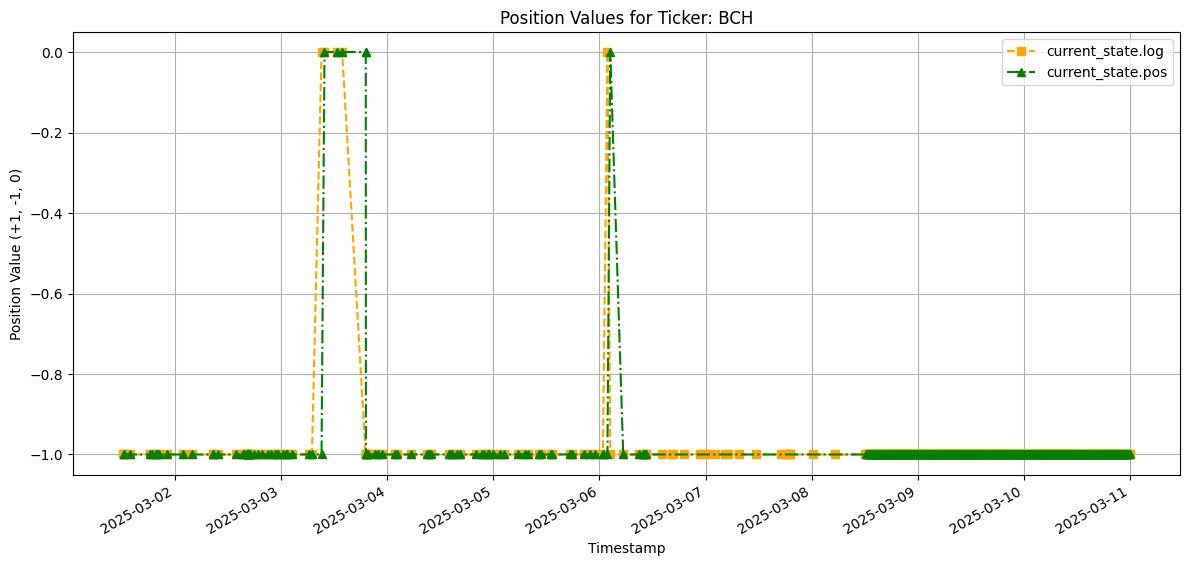

Plotting ticker: BCH
positions_3_df[BCH] shape: (455,), type: <class 'pandas.core.series.Series'>, index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
positions_3_df[BCH] values: 2025-03-01 12:30:00   -1
2025-03-01 13:00:00   -1
2025-03-01 13:30:00   -1
2025-03-01 14:00:00   -1
2025-03-01 14:30:00   -1
Name: BCH, dtype: int64
pos_df[BCH] shape: (486,), type: <class 'pandas.core.series.Series'>


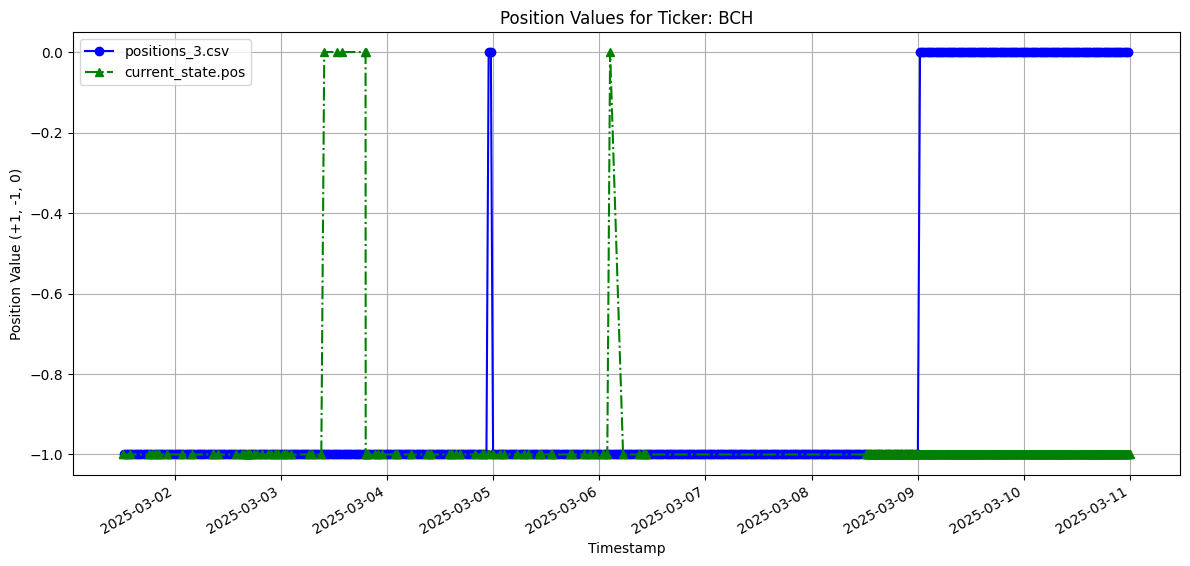

" plot_ticker(positions_3_df, log_df, pos_df, 'DOT', [2,3])\nplot_ticker(positions_3_df, log_df, pos_df, 'DOT', [1,3])\nplot_ticker(positions_3_df, log_df, pos_df, 'BTC', [2,3])\nplot_ticker(positions_3_df, log_df, pos_df, 'BTC', [1,3])\nplot_ticker(positions_3_df, log_df, pos_df, 'MANA', [2,3])\nplot_ticker(positions_3_df, log_df, pos_df, 'MANA', [1,3]) "

In [24]:
plot_ticker(positions_3_df, theo_df, pos_dir_df, 'BCH', [2,3])
plot_ticker(positions_3_df, theo_df, pos_dir_df, 'BCH', [1,3])
""" plot_ticker(positions_3_df, log_df, pos_df, 'DOT', [2,3])
plot_ticker(positions_3_df, log_df, pos_df, 'DOT', [1,3])
plot_ticker(positions_3_df, log_df, pos_df, 'BTC', [2,3])
plot_ticker(positions_3_df, log_df, pos_df, 'BTC', [1,3])
plot_ticker(positions_3_df, log_df, pos_df, 'MANA', [2,3])
plot_ticker(positions_3_df, log_df, pos_df, 'MANA', [1,3]) """

## PNL COMPARISON

### theoretical pnl

Theoretical PNL per trade:
  symbol                 entry_time                  exit_time  side  \
0   AAVE 2025-03-01 12:20:38.977684 2025-03-01 12:24:33.472617     1   
1   ORDI 2025-03-01 12:20:38.977684 2025-03-01 12:24:33.472617    -1   
2   STRK 2025-03-01 12:20:38.977684 2025-03-01 12:24:33.472617    -1   
3    UMA 2025-03-01 12:20:38.977684 2025-03-01 12:24:33.472617    -1   
4    BAT 2025-03-01 12:20:38.977684 2025-03-01 12:26:34.812277    -1   

   theo_pnl  dollar_pnl  
0 -0.000364   -0.000364  
1  0.000700    0.000700  
2  0.000364    0.000364  
3  0.000427    0.000427  
4  0.000192    0.000192  

Portfolio PNL at trade close events:
                            portfolio_dollar_pnl
timestamp                                       
2025-03-01 12:24:33.472617              0.001127
2025-03-01 12:26:34.812277              0.001318
2025-03-01 13:50:38.730289              0.000162
2025-03-01 18:20:35.718483             -0.000008
2025-03-01 18:52:41.515325              0.000389


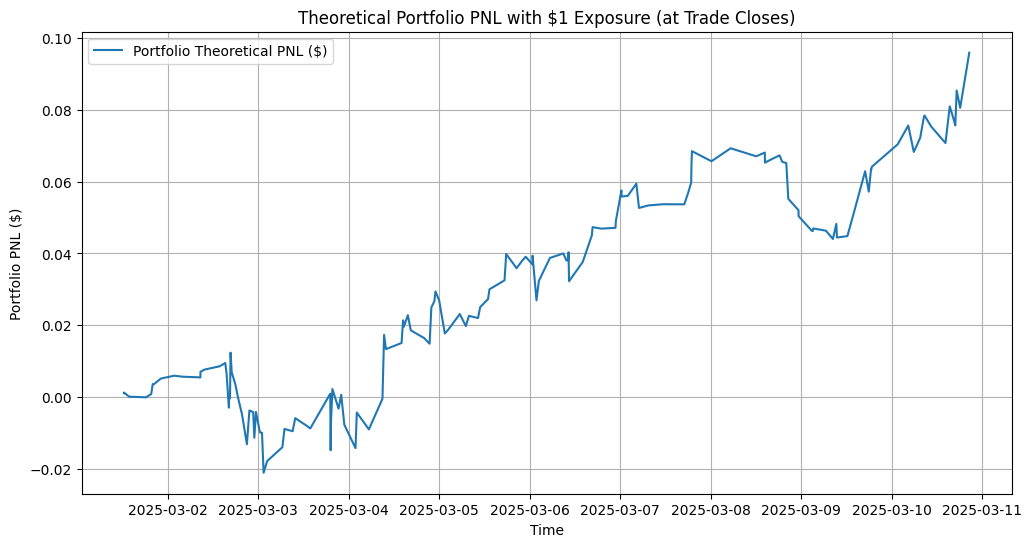

In [25]:
def calculate_theoretical_pnl_from_log_df(log_df: pd.DataFrame, df_prices: pd.DataFrame, number_of_positions: int = 16, exposure: float = 1.0) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Calculate theoretical PNL from log_df and portfolio PNL as a cumulative sum of trade PNLs at close events.
    
    Args:
        log_df (pd.DataFrame): DataFrame with timestamps as index and directional positions (+1, -1, 0).
        df_prices (pd.DataFrame): OHLCV price data with columns like SYMBOL_open, SYMBOL_close.
        number_of_positions (int): Number of positions to divide exposure.
        exposure (float): Total dollar exposure (default $1).
    
    Returns:
        tuple: (df_trades, df_portfolio_pnl)
            - df_trades: DataFrame with trades and theoretical PNL per trade.
            - df_portfolio_pnl: DataFrame with portfolio PNL updated at each trade close.
    """
    open_positions = {}  # {symbol: {"entry_time": ts, "side": int}}
    trades = []
    
    # Step 1: Identify trades
    for ts in log_df.index:
        for symbol in log_df.columns:
            curr_dir = log_df.at[ts, symbol]
            prev_ts = log_df.index[log_df.index < ts][-1] if ts != log_df.index[0] else None
            prev_dir = log_df.at[prev_ts, symbol] if prev_ts else 0
            
            if prev_dir == 0 and curr_dir != 0:  # Open position
                open_positions[symbol] = {"entry_time": ts, "side": curr_dir}
            elif prev_dir != 0 and curr_dir == 0:  # Close position
                if symbol in open_positions:
                    entry = open_positions[symbol]
                    trades.append({"symbol": symbol, "entry_time": entry["entry_time"], "exit_time": ts, "side": entry["side"]})
                    del open_positions[symbol]
            elif prev_dir != curr_dir and curr_dir != 0:  # Flip position
                if symbol in open_positions:
                    entry = open_positions[symbol]
                    trades.append({"symbol": symbol, "entry_time": entry["entry_time"], "exit_time": ts, "side": entry["side"]})
                    del open_positions[symbol]
                open_positions[symbol] = {"entry_time": ts, "side": curr_dir}
    
    df_trades = pd.DataFrame(trades)
    df_trades["theo_pnl"] = 0.0
    df_trades["dollar_pnl"] = 0.0
    
    # Step 2: Calculate per-trade PNL
    for idx, trade in df_trades.iterrows():
        symbol = trade["symbol"]
        entry_time = trade["entry_time"]
        exit_time = trade["exit_time"]
        side = trade["side"]
        
        open_col = f"{symbol}-USDT-SWAP_open"
        close_col = f"{symbol}-USDT-SWAP_close"
        
        if open_col not in df_prices.columns or close_col not in df_prices.columns:
            print(f"WARNING: Price data missing for {symbol}")
            continue
        
        mask = (df_prices.index >= entry_time) & (df_prices.index <= exit_time)
        df_period = df_prices.loc[mask, [open_col, close_col]].dropna()
        
        if df_period.empty:
            print(f"WARNING: No price data for {symbol} between {entry_time} and {exit_time}")
            continue
        
        returns = (df_period[close_col] / df_period[open_col]) - 1
        if side == -1:
            returns = -returns
        
        total_pnl_pcg = returns.sum() / number_of_positions
        df_trades.loc[idx, "theo_pnl"] = total_pnl_pcg
        df_trades.loc[idx, "dollar_pnl"] = total_pnl_pcg * exposure
    
    # Step 3: Calculate portfolio PNL as cumulative sum of trade PNLs at exit times
    df_trades.sort_values("exit_time", inplace=True)
    df_portfolio_pnl = df_trades[["exit_time", "dollar_pnl"]].copy()
    df_portfolio_pnl.rename(columns={"exit_time": "timestamp"}, inplace=True)
    df_portfolio_pnl["portfolio_dollar_pnl"] = df_portfolio_pnl["dollar_pnl"].cumsum()
    df_portfolio_pnl = df_portfolio_pnl[["timestamp", "portfolio_dollar_pnl"]].drop_duplicates("timestamp", keep="last")
    df_portfolio_pnl.set_index("timestamp", inplace=True)
    
    return df_trades, df_portfolio_pnl

# Usage
df_theo_pnl, df_portfolio_pnl = calculate_theoretical_pnl_from_log_df(theo_df, df_prices, number_of_positions=16, exposure=1.0)
print("Theoretical PNL per trade:")
print(df_theo_pnl.head())
print("\nPortfolio PNL at trade close events:")
print(df_portfolio_pnl.head())
df_theo_pnl.to_csv("theoretical_pnl.csv", index=False)
df_portfolio_pnl.to_csv("portfolio_pnl.csv")

# Plot portfolio PNL
plt.figure(figsize=(12, 6))
plt.plot(df_portfolio_pnl.index.to_numpy(), df_portfolio_pnl["portfolio_dollar_pnl"].to_numpy(), label="Portfolio Theoretical PNL ($)")
plt.xlabel("Time")
plt.ylabel("Portfolio PNL ($)")
plt.title("Theoretical Portfolio PNL with $1 Exposure (at Trade Closes)")
plt.legend()
plt.grid()
plt.savefig("portfolio_theo_pnl_at_closes.png", dpi=300)
plt.show()

In [28]:
def build_event_matrix(df_quantities: pd.DataFrame, df_directions: pd.DataFrame) -> pd.DataFrame:
    """
    Build an event matrix with explicit labels for open, rebalance, and close events.
    
    Args:
        df_quantities (pd.DataFrame): Raw position quantities (timestamps x tickers).
        df_directions (pd.DataFrame): Filtered directions (+1, -1, 0) after dust removal.
    
    Returns:
        pd.DataFrame: Matrix with event labels (e.g., 'open long', 'reb sell short').
    """
    # Align indices and columns
    common_index = df_quantities.index.intersection(df_directions.index)
    common_columns = df_quantities.columns.intersection(df_directions.columns)
    df_quantities = df_quantities.loc[common_index, common_columns].copy()
    df_directions = df_directions.loc[common_index, common_columns].copy()
    
    # Mask quantities with directions
    df_quantities_cleaned = df_quantities.where(df_directions != 0, 0.0)
    
    # Initialize event matrix with NaN (no event)
    df_events = pd.DataFrame(index=df_quantities_cleaned.index, columns=df_quantities_cleaned.columns, dtype='object')
    
    for symbol in df_quantities_cleaned.columns:
        qty_series = df_quantities_cleaned[symbol]
        prev_size = 0.0
        
        for ts, new_size in qty_series.items():
            if prev_size == 0 and new_size != 0:
                event = "open long" if new_size > 0 else "open short"
            elif prev_size != 0 and new_size == 0:
                event = "close long" if prev_size > 0 else "close short"
            elif prev_size != 0 and new_size != 0 and abs(new_size - prev_size) > 1e-6:
                if prev_size > 0:  # Long position
                    event = "reb buy long" if new_size > prev_size else "reb sell long"
                else:  # Short position
                    event = "reb sell short" if new_size < prev_size else "reb buy short"
            else:
                event = None
            
            df_events.at[ts, symbol] = event
            prev_size = new_size
    
    return df_events

Event Matrix:
                                  GRT          BAT         POL   CFX  \
timestamp                                                              
2025-03-01 12:24:33.472600  open long   open short        None  None   
2025-03-01 12:26:34.812200       None         None        None  None   
2025-03-01 13:50:38.730200       None  close short  open short  None   
2025-03-01 18:20:35.718400       None         None        None  None   
2025-03-01 18:52:41.515300       None         None        None  None   

                                   CHZ         APT         ID   AXS   BTC  \
timestamp                                                                   
2025-03-01 12:24:33.472600        None        None       None  None  None   
2025-03-01 12:26:34.812200        None        None       None  None  None   
2025-03-01 13:50:38.730200  open short  open short       None  None  None   
2025-03-01 18:20:35.718400        None        None       None  None  None   
2025-03-01 18:52:41

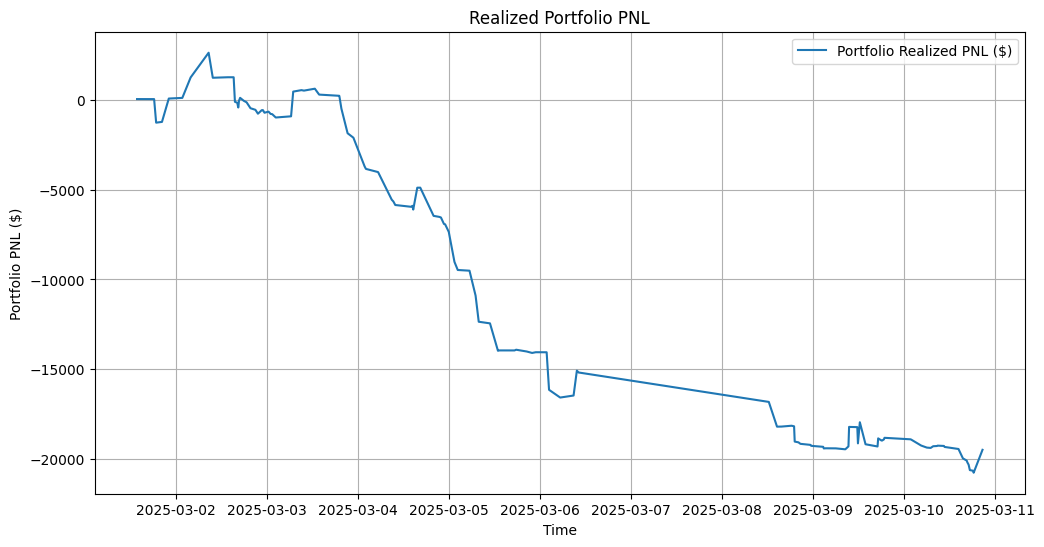

In [32]:
def calculate_realized_pnl_from_matrix(df_events: pd.DataFrame, df_quantities: pd.DataFrame, df_values: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Calculate realized PNL using the event matrix, df_quantities, and df_values (matrix format).
    PNL is realized on close, sell part of long, buy part of short; mean acq price updated only on buy long/sell short.
    
    Args:
        df_events (pd.DataFrame): Event matrix with labels (e.g., 'open long', 'reb sell short').
        df_quantities (pd.DataFrame): Raw position quantities for size tracking (timestamps x tickers).
        df_values (pd.DataFrame): Dollar values (timestamps x tickers).
    
    Returns:
        tuple: (df_position_pnl, df_portfolio_pnl, df_pnl_events)
    """
    open_positions = {}  # {symbol: {"entry_time": ts, "size": float, "total_cost": float, "total_size": float}}
    position_pnl = {}    # {symbol_entry: cumulative_pnl}
    portfolio_pnl = []   # [(timestamp, portfolio_pnl)]
    pnl_events = []
    total_portfolio_pnl = 0.0
    
    # Align df_values and df_quantities with df_events
    common_index = df_events.index.intersection(df_values.index).intersection(df_quantities.index)
    common_columns = df_events.columns.intersection(df_values.columns).intersection(df_quantities.columns)
    df_events = df_events.loc[common_index, common_columns]
    df_values = df_values.loc[common_index, common_columns]
    df_quantities = df_quantities.loc[common_index, common_columns]
    
    for ts in df_events.index:
        for symbol in df_events.columns:
            event = df_events.at[ts, symbol]
            if pd.isna(event):
                continue
            
            # Fetch size and price
            new_size = df_quantities.at[ts, symbol]
            dollar_value = df_values.at[ts, symbol]
            price = dollar_value / new_size if new_size != 0 else 0.0
            
            if event == "open long" or event == "open short":
                open_positions[symbol] = {
                    "entry_time": ts,
                    "size": new_size,
                    "total_cost": new_size * price if new_size > 0 else -new_size * price,
                    "total_size": abs(new_size)
                }
                position_pnl[f"{symbol}_{ts}"] = 0.0
                print(f"{event} {symbol} at {ts}: size={new_size}, price={price}, total_cost={open_positions[symbol]['total_cost']}")
            
            elif event in ["reb buy long", "reb sell long", "reb buy short", "reb sell short"]:
                if symbol not in open_positions:
                    print(f"WARNING: Rebalance without open position for {symbol} at {ts}")
                    continue
                
                pos = open_positions[symbol]
                old_size = pos["size"]
                size_change = old_size - new_size  # Positive if reducing position
                mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                realized_pnl = 0.0
                
                if event == "reb sell long" and old_size > 0:
                    quantity_sold = abs(size_change)
                    realized_pnl = (price - mean_acq_price) * quantity_sold
                    pos["total_cost"] -= mean_acq_price * quantity_sold
                    pos["total_size"] -= quantity_sold
                    pos["size"] = new_size
                    total_portfolio_pnl += realized_pnl
                    # Mean acq price remains the same, no recalculation
                    new_mean_acq_price = mean_acq_price
                elif event == "reb buy long" and old_size > 0:
                    quantity_bought = abs(size_change)
                    pos["total_cost"] += price * quantity_bought
                    pos["total_size"] += quantity_bought
                    pos["size"] = new_size
                    new_mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                elif event == "reb buy short" and old_size < 0:
                    quantity_bought = abs(size_change)
                    realized_pnl = (mean_acq_price - price) * quantity_bought
                    pos["total_cost"] -= mean_acq_price * quantity_bought  # Reduce negative cost
                    pos["total_size"] -= quantity_bought
                    pos["size"] = new_size
                    total_portfolio_pnl += realized_pnl
                    # Mean acq price remains the same, no recalculation
                    new_mean_acq_price = mean_acq_price
                elif event == "reb sell short" and old_size < 0:
                    quantity_sold = abs(size_change)
                    pos["total_cost"] -= price * quantity_sold  # Increase negative cost
                    pos["total_size"] += quantity_sold
                    pos["size"] = new_size
                    new_mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                
                pnl_events.append({
                    "symbol": symbol,
                    "timestamp": ts,
                    "action": event,
                    "price": price,
                    "realized_pnl": realized_pnl,
                    "mean_acq_price": new_mean_acq_price
                })
                if realized_pnl != 0.0:
                    portfolio_pnl.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
                print(f"{event} {symbol} at {ts}: old_size={old_size}, new_size={new_size}, price={price}, realized_pnl={realized_pnl}, new_mean_acq_price={new_mean_acq_price}, portfolio_pnl={total_portfolio_pnl}")
            
            elif event == "close long" or event == "close short":
                if symbol not in open_positions:
                    print(f"WARNING: Close without open position for {symbol} at {ts}")
                    continue
                
                pos = open_positions[symbol]
                old_size = pos["size"]
                mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                if event == "close long":
                    realized_pnl = (price - mean_acq_price) * old_size
                else:  # close short
                    realized_pnl = (mean_acq_price - price) * abs(old_size)
                
                key = f"{symbol}_{pos['entry_time']}"
                position_pnl[key] += realized_pnl
                total_portfolio_pnl += realized_pnl
                pnl_events.append({
                    "symbol": symbol,
                    "timestamp": ts,
                    "action": event,
                    "price": price,
                    "realized_pnl": realized_pnl,
                    "mean_acq_price": mean_acq_price
                })
                portfolio_pnl.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
                print(f"{event} {symbol} at {ts}: size={old_size}, price={price}, realized_pnl={realized_pnl}, portfolio_pnl={total_portfolio_pnl}")
                del open_positions[symbol]
    
    position_records = []
    for key, pnl in position_pnl.items():
        symbol, entry_time = key.rsplit("_", 1)
        entry_time = pd.Timestamp(entry_time)
        exit_time = df_events[
            df_events[symbol].isin(["close long", "close short"]) &
            (df_events.index >= entry_time)
        ].index.min()
        position_records.append({
            "symbol": symbol,
            "entry_time": entry_time,
            "exit_time": exit_time,
            "realized_pnl": pnl
        })
    
    df_position_pnl = pd.DataFrame(position_records)
    df_portfolio_pnl = pd.DataFrame(portfolio_pnl).drop_duplicates(subset="timestamp", keep="last")
    df_pnl_events = pd.DataFrame(pnl_events)
    return df_position_pnl, df_portfolio_pnl, df_pnl_events

# Notebook integration (build_event_matrix unchanged)
df_events_matrix = build_event_matrix(qty_df, pos_dir_df)
print("Event Matrix:")
print(df_events_matrix.head())
df_events_matrix.to_csv("events_matrix.csv")

print("\nCalculating Realized PNL from Event Matrix...")
df_position_pnl, df_portfolio_pnl, df_pnl_events = calculate_realized_pnl_from_matrix(df_events_matrix, qty_df, values_df)
print("Position PNL:")
print(df_position_pnl.head())
print("\nPortfolio PNL at realization events:")
print(df_portfolio_pnl.head())
print("\nPNL Events:")
print(df_pnl_events.head())
df_position_pnl.to_csv("position_pnl.csv", index=False)
df_portfolio_pnl.to_csv("realized_portfolio_pnl.csv", index=False)
df_pnl_events.to_csv("pnl_events.csv", index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_portfolio_pnl["timestamp"].to_numpy(), df_portfolio_pnl["portfolio_pnl"].to_numpy(), label="Portfolio Realized PNL ($)")
plt.xlabel("Time")
plt.ylabel("Portfolio PNL ($)")
plt.title("Realized Portfolio PNL")
plt.legend()
plt.grid()
plt.savefig("realized_portfolio_pnl.png", dpi=300)
plt.show()

In [30]:
# Notebook integration
df_events_matrix = build_event_matrix(qty_df, pos_dir_df)
print("Event Matrix:")
print(df_events_matrix.head())
df_events_matrix.to_csv("events_matrix.csv")

print("\nCalculating Realized PNL from Event Matrix...")
df_position_pnl, df_portfolio_pnl, df_pnl_events = calculate_realized_pnl_from_matrix(df_events_matrix, qty_df, values_df)
print("Position PNL:")
print(df_position_pnl.head())
print("\nPortfolio PNL at realization events:")
print(df_portfolio_pnl.head())
print("\nPNL Events:")
print(df_pnl_events.head())
df_position_pnl.to_csv("position_pnl.csv", index=False)
df_portfolio_pnl.to_csv("realized_portfolio_pnl.csv", index=False)
df_pnl_events.to_csv("pnl_events.csv", index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_portfolio_pnl["timestamp"].to_numpy(), df_portfolio_pnl["portfolio_pnl"].to_numpy(), label="Portfolio Realized PNL ($)", marker='o')
plt.xlabel("Time")
plt.ylabel("Portfolio PNL ($)")
plt.title("Realized Portfolio PNL")
plt.legend()
plt.grid()
plt.savefig("realized_portfolio_pnl.png", dpi=300)
plt.show()

Event Matrix:
                                  GRT          BAT         POL   CFX  \
timestamp                                                              
2025-03-01 12:24:33.472600  open long   open short        None  None   
2025-03-01 12:26:34.812200       None         None        None  None   
2025-03-01 13:50:38.730200       None  close short  open short  None   
2025-03-01 18:20:35.718400       None         None        None  None   
2025-03-01 18:52:41.515300       None         None        None  None   

                                   CHZ         APT         ID   AXS   BTC  \
timestamp                                                                   
2025-03-01 12:24:33.472600        None        None       None  None  None   
2025-03-01 12:26:34.812200        None        None       None  None  None   
2025-03-01 13:50:38.730200  open short  open short       None  None  None   
2025-03-01 18:20:35.718400        None        None       None  None  None   
2025-03-01 18:52:41

TypeError: cannot unpack non-iterable NoneType object